In [3]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy.sparse import dok_matrix
from stop_words import get_stop_words
from dateutil.parser import parse
from datetime import datetime, timedelta
from collections import defaultdict
from nltk import WordNetLemmatizer
import numpy as np
import json

# wordnet lemmatizer - 복수형을 단수형으로 바꿔줌
wnl = WordNetLemmatizer()

In [4]:
with open("twit_new.json", "r") as f:
    data = json.load(f)

# 각 트윗이 발생한 시간들 수집
times = set()
for twit in data:
    time = parse(twit['postedTime']).replace(tzinfo=None).date()
    times.add(time)

times = sorted(times)

In [5]:
times_twits = defaultdict(list)
tweets_original = []
voca = set()

for twit in data:
    # 시간을 30분 단위로 반올림
    time = parse(twit['postedTime']).replace(tzinfo=None).date()

    # 단어가 3개 이상인 트윗만 취급
    body = twit['body']
    body = body.split()
    if len(body) > 3:
        # lemmatize
        body = [wnl.lemmatize(t) for t in body if t.isalpha()]
        voca.update(body)
        body = " ".join(body)

        # 각 트윗을 시간에 따라 묶음
        times_twits[time].append(body)
        # 문서 검색용으로 별도로 저장
        tweets_original.append(twit['body'])

del data

In [6]:
# stopwords 제거
stopwords = set(get_stop_words('en'))
stopwords.update(['via', 'will', 'just', 'one', 'don', 'lol', 'yes', 'doe'])
voca = {v for v in voca if len(v) > 2}
voca = list(voca - stopwords)
voca_id = {w: i for i, w in enumerate(voca)}

In [7]:
# 각 시간별 term document matrix 생성
tdm = dok_matrix((len(times), len(voca)), dtype=np.float32)
for i, time in enumerate(times):
    for twit in times_twits[time]:
        for word in twit.split():
            try:
                tdm[i, voca_id[word]] += 1
            except:
                # stopwords
                continue

tdm_ = normalize(tdm)
print(tdm_.shape)

(92, 14465)


In [8]:
# NMF
K = 7
n_words = 30
nmf = NMF(n_components=K, init='nndsvd', max_iter=500, alpha=0.1)
W = nmf.fit_transform(tdm_)
H = nmf.components_

for k in range(K):
    print(f"{k}th topic")
    for index in H[k].argsort()[::-1][:n_words]:
        print(voca[index], end=" ")
    print("\n")

0th topic
ransomware attack can new cybersecurity threat security business malware protect hit data user backup file now lazarus healthcare say ransom cyber know infosec victim cybercrime report locky rise target webinar 

1th topic
wannacry ransomware attack cybersecurity window malware infosec security wannacrypt cyber cyberattack nsa tool patch smb like protect microsoft now step can eternalblue fintech hacking hit computer bitcoin system know update 

2th topic
ransomware cybersecurity security malware cyberattacks infosec hacker iot infographic business cybercrime internet thing protect hacking cyberattack attack step databreach pay bigdata top cloud learn iotsecurity makeyourownlane exploit major cyber threat 

3th topic
ransomware infosec security new cybercrime infographic lazarus internet tool cyberattacks thing decryption free iot get protect available enterprise xgen concerned play powered endpoint dead game week ransom attack client time 

4th topic
ransomware malware iot e

In [9]:
from bokeh.models import HoverTool
from bokeh.palettes import Category20
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
output_notebook()

W_ = W.T  # 시간별 토픽 가중치
times_str = [str(t) for t in times]  # x축에 표시할 시간 문자열

# 사용할 툴들
tools_to_show = 'hover,box_zoom,pan,save,resize,reset,wheel_zoom'
p = figure(
    plot_width=800,
    plot_height=500,
    x_axis_type="datetime",
    tools=tools_to_show)

for k in range(K):
    # 각 토픽별 그래프에 추가하도록 source data 생성
    source = ColumnDataSource(data={
        'x': times,  # x축
        'v': W_[k],  # 해당 토픽 가중치
        'x_str': times_str,  # x축 문자열
        'name': [str(k) for _ in range(W_.shape[1])]  # 토픽 번호를 각 시간마다 알려줌
    })
    p.line('x', 'v', source=source, legend=str(k), color=Category20[K][k])

# 몇가지 interaction
p.legend.location = "top_left"
p.legend.click_policy = "hide"
hover = p.select(dict(type=HoverTool))
hover.tooltips = [("value", "@v"), ("topic", "@name"), ("date", "@x_str")]
hover.mode = 'mouse'

show(p)

Loading BokehJS ...

/Users/Helianthus/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: ResizeTool is removed in Bokeh 0.12.7, adding it is a no-op. In the future, accessing ResizeTool will be an error
  warn(message)


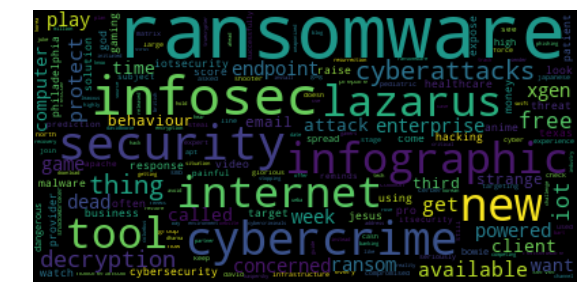

In [14]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 각 단어 가중치
word_freq = {}
for i, word in enumerate(voca):
    word_freq[word] = H[3, i]

# wordcloud 생성
wordcloud = WordCloud().generate_from_frequencies(word_freq)

# wordcloud를 matplotlib을 이용해서 출력
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

In [15]:
# 검색을 할 때 모든 문장에 대해 단어를 검색하는 것은 매우 느림!
# term document matrix를 만들어서 해당 단어를 포함하는 문장을 바로 찾자
tdm2 = dok_matrix((len(tweets_original), len(voca)), dtype=np.uint16)
for i, tweet in enumerate(tweets_original):
    tweet = [wnl.lemmatize(t) for t in tweet.split() if t.isalpha()]
    for word in tweet:
        try:
            tdm2[i, voca_id[word]] += 1
        except:
            # stopwords
            continue

# dok_matrix 보다 csr format의 sparse matrix가 연산이 더 빠름(단, 삽입 연산은 느림)
tdm2 = tdm2.tocsr()

In [16]:
query = input("input keyword:")  # 검색할 단어 인풋을 받음
# 해당 단어(query)의 빈도가 0이 아닌 모든 문장을 찾아(nonzero()) 그 중 20개 트윗을 반환
print()
for i in tdm2[:, voca_id[query]].nonzero()[0][:10]:
    print(tweets_original[i])

input keyword:wannacry

4 hour rehearsal today for movement specialists wannacry thisdanceissodopethough
vid got me emosh ma nigga wannacry
welp painsomnia is a bitch spoonie fuckfibro wannacry spooniegifparty
here is the wannacry ransomware report sample that allegedly hit a large telcom today
here is the wannacry ransomware report sample that allegedly hit a large telcom today
here is the wannacry ransomware report sample that allegedly hit a large telcom today
here is the wannacry ransomware report sample that allegedly hit a large telcom today
here is the wannacry ransomware report sample that allegedly hit a large telcom today
here is the wannacry ransomware report sample that allegedly hit a large telcom today
this is the wannacry ransomware that everyone in spain latam talks about today dfir cc
